In [1]:
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import os
from scipy import stats
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.stats import gaussian_kde

In [2]:
IDir = r'/Volumes/PhD/imagery/masters/output/dNBR/'
ODir = r'/Volumes/PhD/imagery/masters/ROC/'
basin_path = r'/Volumes/PhD/imagery/masters/ROC/ROC_basins.shp'
basins_df = gpd.read_file(basin_path)
basin_id = basins_df['BASIN_ID']
basin_df = pd.DataFrame(basin_id)
basin_df

,BASIN_ID
0,17499
1,3115
2,3589
3,5683
4,5920
...,...
732,15065
733,35852
734,36553
735,36955


In [5]:
def M1(dnbr, basin_data,
          save=False):
    
    # Coefficients for Southern California
    b = -3.63
    b_1 = 0.41
    b_2 = 0.67
    b_3 = 0.7
    

    results = []

    for basin_id, basin_row in basin_data.iterrrows():
        # File naming
        dnbr_flat = dnbr.values.flatten()
        pixarr = np.empty((dnbr_flat.shape[0]), dtype= float)
        pixarr[:] = np.nan
        x = np.where(np.isnan(dnbr_flat) == False)
            
        # Getting the data from dnbr_flat
        dnbrdata = dnbr_flat[x]
        dnbrdata = np.mean(dnbrdata)
            
        # Pulling tif metadata
        metadata = dnbr.attrs
        x_1 = float(metadata.get('X1'))
        x_3 = float(metadata.get('X3'))
        
        R = basin_row['RI']

        lnx =  b + (b_1 * x_1 * R) + (b_2 * dnbrdata * R) + (b_3 * x_3 * R)
        prob = (e ** lnx) / (1.0 + e ** lnx)
        results.append({'BASIN_ID': basin_id, 'Probability': prob})
    results_df = pd.DataFrame(results)
    return results_df

In [6]:
def calculate_image_statistics(dnbr_dir, basin_data):
    # Ensure BASIN_ID is string to match filenames
    basin_data["BASIN_ID"] = basin_data["BASIN_ID"].astype(str)

    # Get a list of all files in the directory
    file_list = os.listdir(dnbr_dir)

    # Initialize lists to store the computed statistics
    mean_list = []
    median_list = []
    peak_frequency_list = []

    # Loop through each row in basin_data
    for index, row in basin_data.iterrows():
        basin_id = row["BASIN_ID"]

        # Construct the expected file name
        file_name = f"basin_{basin_id}_dNBR.tif"

        # Check if the file exists
        if file_name not in file_list:
            print(f"No matching file for Basin_ID: {basin_id}")
            mean_list.append(np.nan)
            median_list.append(np.nan)
            peak_frequency_list.append(np.nan)
            continue

        # Full path to the matching file
        file_path = os.path.join(dnbr_dir, file_name)

        try:
            # Open the raster file
            with rasterio.open(file_path) as src:
                dnbr_data = src.read(1)  # Read the first band
                dnbr_data = dnbr_data.astype(float)  # Ensure it's float for calculations
                
                # Replace nodata values with NaN
                dnbr_data[dnbr_data == src.nodata] = np.nan

                # Calculate statistics
                mean_value = np.nanmean(dnbr_data)
                median_value = np.nanmedian(dnbr_data)
                
                # Calculate peak frequency
                valid_data = dnbr_data[~np.isnan(dnbr_data)]  # Remove NaNs
                rounded_data = np.round(valid_data, 4)
                #peak_frequency = statistics.mode(rounded_data)
                
                kde = gaussian_kde(valid_data)

                # Define a grid of values for evaluation
                x_grid = np.linspace(valid_data.min(), valid_data.max(), 1000)

                # Evaluate KDE on the grid
                kde_values = kde(x_grid)

                # Find the peak value
                peak_index = kde_values.argmax()  # Index of the maximum KDE value
                peak_frequency = x_grid[peak_index]

                # Append statistics to lists
                mean_list.append(mean_value)
                median_list.append(median_value)
                peak_frequency_list.append(peak_frequency)

        except Exception as e:
            print(f"Error processing Basin_ID {basin_id}: {e}")
            mean_list.append(np.nan)
            median_list.append(np.nan)
            peak_frequency_list.append(np.nan)

    # Add the calculated statistics to basin_data
    basin_data["Mean_dNBR"] = mean_list
    basin_data["Med_dNBR"] = median_list
    basin_data["PF_dNBR"] = peak_frequency_list

    return basin_data

In [7]:
x_df = calculate_image_statistics(IDir, basin_df)
x_df


,BASIN_ID,Mean_dNBR,Med_dNBR,PF_dNBR
0,17499,0.471854,0.477169,0.459052
1,3115,0.072363,0.014718,-0.019005
2,3589,0.216498,0.051373,-0.020064
3,5683,0.692429,0.702799,0.724929
4,5920,0.605956,0.651802,0.753237
...,...,...,...,...
732,15065,0.164376,0.111513,0.055359
733,35852,0.284851,0.279801,0.261897
734,36553,0.348485,0.339397,0.331989
735,36955,0.208930,0.202108,0.175856


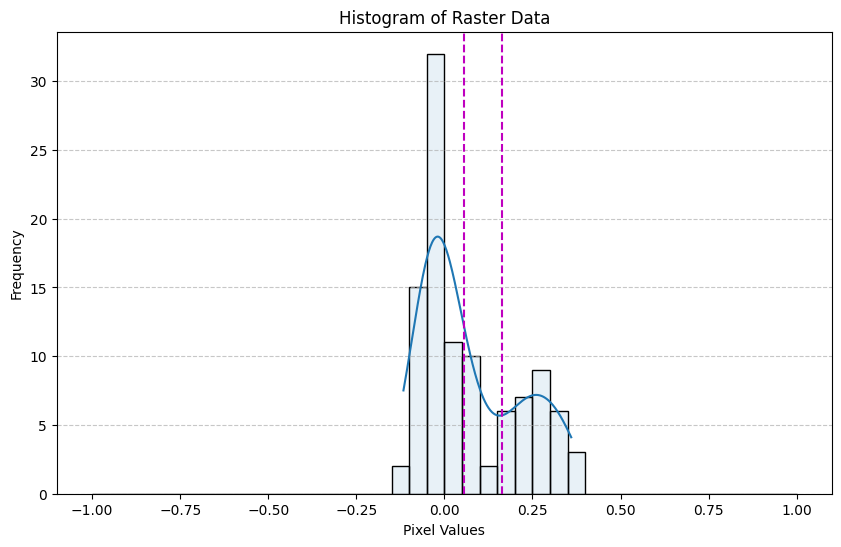

In [9]:
dnbr_c = r'/Volumes/PhD/imagery/masters/output/dNBR/basin_3115_dNBR.tif'
dnbr_c = rxr.open_rasterio(dnbr_c)
dnbr_array = dnbr_c.values

# Flatten the array and remove NaN values
valid_data = dnbr_array.flatten()
valid_data = valid_data[~np.isnan(valid_data)]

# Plot the histogram
bin = np.arange(-1, 1.05, 0.05)
plt.figure(figsize=(10, 6))
sns.histplot(valid_data, bins=bin, kde=True, alpha=.1)
plt.axvline(x=.055359, color='m', linestyle='--')
plt.axvline(x=.164376, color='m', linestyle='--')

#plt.hist(valid_data, bins=bin, color='blue', alpha=0.7, edgecolor='black')  # Adjust bins as needed
plt.title("Histogram of Raster Data")
plt.xlabel("Pixel Values")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [142]:
x_df['BASIN_ID'] = x_df['BASIN_ID'].astype(int)
print(x_df)
merged_gdf = gpd.GeoDataFrame(
    pd.merge(basins_df, x_df, on="BASIN_ID", how="left")
)

# Check the result
print(merged_gdf['PF_dNBR'])

     BASIN_ID  Mean_dNBR  Med_dNBR   PF_dNBR
0       17499   0.471854  0.477169  0.459052
1        3115   0.072363  0.014718 -0.019005
2        3589   0.216498  0.051373 -0.020064
3        5683   0.692429  0.702799  0.724929
4        5920   0.605956  0.651802  0.753237
..        ...        ...       ...       ...
732     15065   0.164376  0.111513  0.055359
733     35852   0.284851  0.279801  0.261897
734     36553   0.348485  0.339397  0.331989
735     36955   0.208930  0.202108  0.175856
736     37056   0.226340  0.245195  0.296599

[737 rows x 4 columns]
0      0.459052
1     -0.019005
2     -0.020064
3      0.724929
4      0.753237
         ...   
732    0.055359
733    0.261897
734    0.331989
735    0.175856
736    0.296599
Name: PF_dNBR, Length: 737, dtype: float64


In [143]:
merged_gdf.to_file(os.path.join(ODir + 'M1_ROC.shp'))